# Initialization

## Installs

In [1]:
!pip install ivy-core
!pip install ivy-vision
!pip install tensorflow
!pip install tensorflow-addons

     |████████████████████████████████| 228 kB 17.7 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 462 kB 24.0 MB/s 
     |████████████████████████████████| 1.1 MB 24.6 MB/s 


## Imports

In [2]:
import ivy
import cv2
import requests
import ivy_vision
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

## Plot Config

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]

## Download Data

In [4]:
files = {'cam1_inv_ext_mat.npy': '1BoQCjs1NkhlkcQGOpwD-lMtP0qf4hRJT',
         'cam2_inv_ext_mat.npy': '1to-9fDDJPlq7qUb_KzAsVuPpKrV6_VeA',
         'depth1.png': '1SYB27MfazMB_-3dbK1wLnjShufccy_gd',
         'depth2.png': '1BM7qVJlr-FaG8di8LYx8WlamqIP8Aa_2',
         'rgb1.png': '1Z7RrTBT_nuoOWqUSFbBR_-qgROLVdvtx',
         'rgb2.png': '1fWOlJb-808_bBWGVi0Uejl9pWm44lpr5'}

for fname, file_id in files.items():
  gdd.download_file_from_google_drive(
      file_id=file_id,
      dest_path='/content/' + fname)

## Set Backend Framework

In [5]:
ivy.set_framework('tensorflow')

## Helper Functions

In [6]:
b = 12
bo2 = int(b/2)
s = 512


def flow_to_image(flow):
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    idxUnknow = (abs(u) > 1e7) | (abs(v) > 1e7)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u / (maxrad + np.finfo(float).eps + 1e-12)
    v = v / (maxrad + np.finfo(float).eps + 1e-12)

    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / (RY + 1e-12)))
    col += RY

    # YG
    colorwheel[col:col + YG, 0] = 255 - np.transpose(np.floor(255 * np.arange(0, YG) / (YG + 1e-12)))
    colorwheel[col:col + YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / (GC + 1e-12)))
    col += GC

    # CB
    colorwheel[col:col + CB, 1] = 255 - np.transpose(np.floor(255 * np.arange(0, CB) / (CB + 1e-12)))
    colorwheel[col:col + CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / (BM + 1e-12)))
    col += + BM

    # MR
    colorwheel[col:col + MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / (MR + 1e-12)))
    colorwheel[col:col + MR, 0] = 255

    ncols = np.size(colorwheel, 0)
    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1
    f_ = fk - k0

    for i in range(0, np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0 - 1] / 255
        col1 = tmp[k1 - 1] / 255
        col = (1 - f_) * col0 + f_ * col1

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - nanIdx)))

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return img/255


def add_top_left_corner_text(img, text_str, x_len, y_len, t=3, fs=1.0):
    img[0:y_len, 0:x_len] = np.zeros_like(img[0:y_len, 0:x_len])
    img[t:y_len-t, t:x_len-t] = np.ones_like(img[t:y_len-t, t:x_len-t])
    cv2.putText(img, text_str, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, fs, tuple([0] * 3), 2)


def show_rgb_and_depth_images(col1, col2, dep1, dep2, dep_lims):

    final_img = np.zeros((s+2*b, 4*s+2*b, 3))

    col1_img = np.copy(np.flip(ivy.to_numpy(col1), -1))
    add_top_left_corner_text(col1_img, 'color 1', 140, 44, 6)

    col2_img = np.copy(np.flip(ivy.to_numpy(col2), -1))
    add_top_left_corner_text(col2_img, 'color 2', 140, 44, 6)

    dep_min = ivy.to_numpy(dep_lims[0]).reshape(()).item()
    depth_range = ivy.to_numpy(dep_lims[1] - dep_lims[0]).reshape(()).item()

    depth1_normed = (ivy.to_numpy(dep1) - dep_min) / depth_range
    depth1_img = np.tile(depth1_normed, (1, 1, 3))
    add_top_left_corner_text(depth1_img, 'depth 1', 150, 44, 6)

    depth2_normed = (ivy.to_numpy(dep2) - dep_min) / depth_range
    depth2_img = np.tile(depth2_normed, (1, 1, 3))
    add_top_left_corner_text(depth2_img, 'depth 2', 150, 44, 6)

    final_img[b:-b, b:-b] = np.concatenate((col1_img, col2_img, depth1_img, depth2_img), 1)
    final_img[:, s+bo2:s+3*bo2] = 0.
    final_img[:, 2*s+bo2:2*s+3*bo2] = 0.
    final_img[:, 3*s+bo2:3*s+3*bo2] = 0.

    plt.imshow(np.clip(final_img, 0, 1))
    plt.show()


def show_flow_and_depth_images(dep1, f1to2, dep1_from_flow, dep_lims):

    final_img = np.zeros((s+2*b, 3*s+2*b, 3))

    dep_min = ivy.to_numpy(dep_lims[0]).reshape(()).item()
    depth_range = ivy.to_numpy(dep_lims[1] - dep_lims[0]).reshape(()).item()

    depth1_normed = (ivy.to_numpy(dep1) - dep_min) / depth_range
    depth1_img = np.tile(depth1_normed, (1, 1, 3))
    add_top_left_corner_text(depth1_img, 'depth 1', 150, 44, 6)

    flow_img = flow_to_image(np.copy(ivy.to_numpy(f1to2)))
    add_top_left_corner_text(flow_img, 'flow 1 to 2', 215, 44, 6)

    depth1_from_flow_normed = (ivy.to_numpy(dep1_from_flow) - dep_min) / depth_range
    depth1_from_flow_img = np.tile(depth1_from_flow_normed, (1, 1, 3))
    add_top_left_corner_text(depth1_from_flow_img, 'depth 1 from flow', 325, 44, 6)

    final_img[b:-b, b:-b] = np.concatenate((depth1_img, flow_img, depth1_from_flow_img), 1)
    final_img[:, s+bo2:s+3*bo2] = 0.
    final_img[:, 2*s+bo2:2*s+3*bo2] = 0.

    plt.imshow(np.clip(final_img, 0, 1))
    plt.show()


def show_inverse_warped_images(dep1_wrt_f2, dep2_warp_to_f1, dep_val,
                               col1, col2_warp_to_f1, col2_warp_to_f1_masked, dep_lims):

    final_img = np.zeros((2*s+2*b, 3*s+2*b, 3))
    dep_min = ivy.to_numpy(dep_lims[0]).reshape(()).item()
    depth_range = ivy.to_numpy(dep_lims[1] - dep_lims[0]).reshape(()).item()

    dep1_wrt_f2_normed = (ivy.to_numpy(dep1_wrt_f2) - dep_min) / depth_range
    dep1_wrt_f2_img = np.tile(dep1_wrt_f2_normed, (1, 1, 3))
    add_top_left_corner_text(dep1_wrt_f2_img, 'depth 1 wrt f2', 265, 44, 6)

    dep2_warp_to_f1_normed = (ivy.to_numpy(dep2_warp_to_f1) - dep_min) / depth_range
    dep2_warp_to_f1_img = np.tile(dep2_warp_to_f1_normed, (1, 1, 3))
    add_top_left_corner_text(dep2_warp_to_f1_img, 'depth 2 warped to f1', 375, 44, 6)

    dep_val = ivy.to_numpy(dep_val).astype(np.float32)
    dep_val_img = np.tile(dep_val, (1, 1, 3))
    add_top_left_corner_text(dep_val_img, 'depth validity', 240, 44, 6)

    col1_img = np.copy(np.flip(ivy.to_numpy(col1), -1))
    add_top_left_corner_text(col1_img, 'color 1', 140, 44, 6)

    col2_warp_to_f1_img = np.copy(np.flip(ivy.to_numpy(col2_warp_to_f1), -1))
    add_top_left_corner_text(col2_warp_to_f1_img, 'color 2 warped to f1', 360, 44, 6)

    col2_warp_to_f1_masked_img = np.copy(np.flip(ivy.to_numpy(col2_warp_to_f1_masked), -1))
    add_top_left_corner_text(col2_warp_to_f1_masked_img, 'rendering in f1', 175, 44, 6)

    top_half = np.concatenate((dep1_wrt_f2_img, dep2_warp_to_f1_img, dep_val_img), 1)
    bottom_half = np.concatenate((col1_img, col2_warp_to_f1_img, col2_warp_to_f1_masked_img), 1)

    final_img[b:-b, b:-b] = np.concatenate((top_half, bottom_half), 0)
    final_img[:, s+bo2:s+3*bo2] = 0.
    final_img[:, 2*s+bo2:2*s+3*bo2] = 0.
    final_img[:, 3*s+bo2:3*s+3*bo2] = 0.
    final_img[s+bo2:s+3*bo2] = 0.

    plt.imshow(np.clip(final_img, 0, 1))
    plt.show()


def show_forward_warped_images(dep1, col1, f1_f_warp_no_db, f1_f_warp_w_db, dep_lims):

    final_img = np.zeros((2*s+2*b, 3*s+2*b, 3))
    dep_min = ivy.to_numpy(dep_lims[0]).reshape(()).item()
    depth_range = ivy.to_numpy(dep_lims[1] - dep_lims[0]).reshape(()).item()

    dep1_normed = (ivy.to_numpy(dep1) - dep_min) / depth_range
    dep1_img = np.tile(dep1_normed, (1, 1, 3))
    add_top_left_corner_text(dep1_img, 'depth 1', 150, 44, 6)

    dep2_wrt_f1_warped_to_f1_no_db = f1_f_warp_no_db[..., 2:3]
    dep2_wrt_f1_warped_to_f1_no_db_normed = (ivy.to_numpy(dep2_wrt_f1_warped_to_f1_no_db) - dep_min) / depth_range
    dep2_wrt_f1_warped_to_f1_no_db_img = np.tile(dep2_wrt_f1_warped_to_f1_no_db_normed, (1, 1, 3))
    add_top_left_corner_text(dep2_wrt_f1_warped_to_f1_no_db_img, 'depth 2 wr+wrpd to f1 no db', 500, 44, 6)

    dep2_wrt_f1_warped_to_f1_w_db = f1_f_warp_w_db[..., 2:3]
    dep2_wrt_f1_warped_to_f1_w_db_normed = (ivy.to_numpy(dep2_wrt_f1_warped_to_f1_w_db) - dep_min) / depth_range
    dep2_wrt_f1_warped_to_f1_w_db_img = np.tile(dep2_wrt_f1_warped_to_f1_w_db_normed, (1, 1, 3))
    add_top_left_corner_text(dep2_wrt_f1_warped_to_f1_w_db_img, 'depth 2 wr+wrpd to f1 w db', 485, 44, 6)

    col1_img = np.copy(np.flip(ivy.to_numpy(col1), -1))
    add_top_left_corner_text(col1_img, 'color 1', 140, 44, 6)

    col2_warped_to_f1_no_db = f1_f_warp_no_db[..., 3:]
    col2_warp_to_f1_no_db_img = np.copy(np.flip(ivy.to_numpy(col2_warped_to_f1_no_db), -1))
    add_top_left_corner_text(col2_warp_to_f1_no_db_img, 'color 2 warped to f1 no db', 470, 44, 6)

    col2_warped_to_f1_w_db = f1_f_warp_w_db[..., 3:]
    col2_warp_to_f1_w_db_img = np.copy(np.flip(ivy.to_numpy(col2_warped_to_f1_w_db), -1))
    add_top_left_corner_text(col2_warp_to_f1_w_db_img, 'color 2 warped to f1 w db', 455, 44, 6)

    top_half = np.concatenate((dep1_img, dep2_wrt_f1_warped_to_f1_no_db_img, dep2_wrt_f1_warped_to_f1_w_db_img), 1)
    bottom_half = np.concatenate((col1_img, col2_warp_to_f1_no_db_img, col2_warp_to_f1_w_db_img), 1)

    final_img[b:-b, b:-b] = np.concatenate((top_half, bottom_half), 0)
    final_img[:, s+bo2:s+3*bo2] = 0.
    final_img[:, 2*s+bo2:2*s+3*bo2] = 0.
    final_img[:, 3*s+bo2:3*s+3*bo2] = 0.
    final_img[s+bo2:s+3*bo2] = 0.

    plt.imshow(np.clip(final_img, 0, 1))
    plt.show()

# Camera Geometry

## Intrinsics

In [7]:
# common intrinsic params
img_dims = [512, 512]
pp_offsets = ivy.array([dim / 2 - 0.5 for dim in img_dims], 'float32')
cam_persp_angles = ivy.array([60 * np.pi / 180] * 2, 'float32')

# ivy cam intrinsics container
intrinsics = ivy_vision.persp_angles_and_pp_offsets_to_intrinsics_object(
    cam_persp_angles, pp_offsets, img_dims)

## Extrinsics

In [8]:
# 3 x 4
cam1_inv_ext_mat = ivy.array(np.load('cam1_inv_ext_mat.npy'), 'float32')
cam2_inv_ext_mat = ivy.array(np.load('cam2_inv_ext_mat.npy'), 'float32')

## Full Geometry

In [9]:
# ivy cam geometry container
cam1_geom = ivy_vision.inv_ext_mat_and_intrinsics_to_cam_geometry_object(
    cam1_inv_ext_mat, intrinsics)
cam2_geom = ivy_vision.inv_ext_mat_and_intrinsics_to_cam_geometry_object(
    cam2_inv_ext_mat, intrinsics)
cam_geoms = [cam1_geom, cam2_geom]

## Verification

In [10]:
for cam_geom in cam_geoms:
  
  assert cam_geom.intrinsics.focal_lengths.shape == (2,)
  assert cam_geom.intrinsics.persp_angles.shape == (2,)
  assert cam_geom.intrinsics.pp_offsets.shape == (2,)
  assert cam_geom.intrinsics.calib_mats.shape == (3, 3)
  assert cam_geom.intrinsics.inv_calib_mats.shape == (3, 3)

  assert cam_geom.extrinsics.cam_centers.shape == (3, 1)
  assert cam_geom.extrinsics.Rs.shape == (3, 3)
  assert cam_geom.extrinsics.inv_Rs.shape == (3, 3)
  assert cam_geom.extrinsics.ext_mats_homo.shape == (4, 4)
  assert cam_geom.extrinsics.inv_ext_mats_homo.shape == (4, 4)

  assert cam_geom.full_mats_homo.shape == (4, 4)
  assert cam_geom.inv_full_mats_homo.shape == (4, 4)

# Images

## Load

### Color

In [11]:
# h x w x 3
color1 = ivy.array(cv2.imread('rgb1.png').astype(np.float32) / 255)
color2 = ivy.array(cv2.imread('rgb2.png').astype(np.float32) / 255)

### Depth

In [12]:
# h x w x 1
depth1 = ivy.array(np.reshape(np.frombuffer(cv2.imread(
    'depth1.png', -1).tobytes(), np.float32), img_dims + [1]))
depth2 = ivy.array(np.reshape(np.frombuffer(cv2.imread(
    'depth2.png', -1).tobytes(), np.float32), img_dims + [1]))

## Depth-Scaled Pixel Coordinates

In [13]:
# h x w x 3
u_pix_coords = ivy_vision.create_uniform_pixel_coords_image(img_dims)
ds_pixel_coords1 = u_pix_coords * depth1
ds_pixel_coords2 = u_pix_coords * depth2

## Depth Limits

In [14]:
depth_min = ivy.reduce_min(ivy.concatenate((depth1, depth2), 0))
depth_max = ivy.reduce_max(ivy.concatenate((depth1, depth2), 0))
depth_limits = [depth_min, depth_max]

## Show

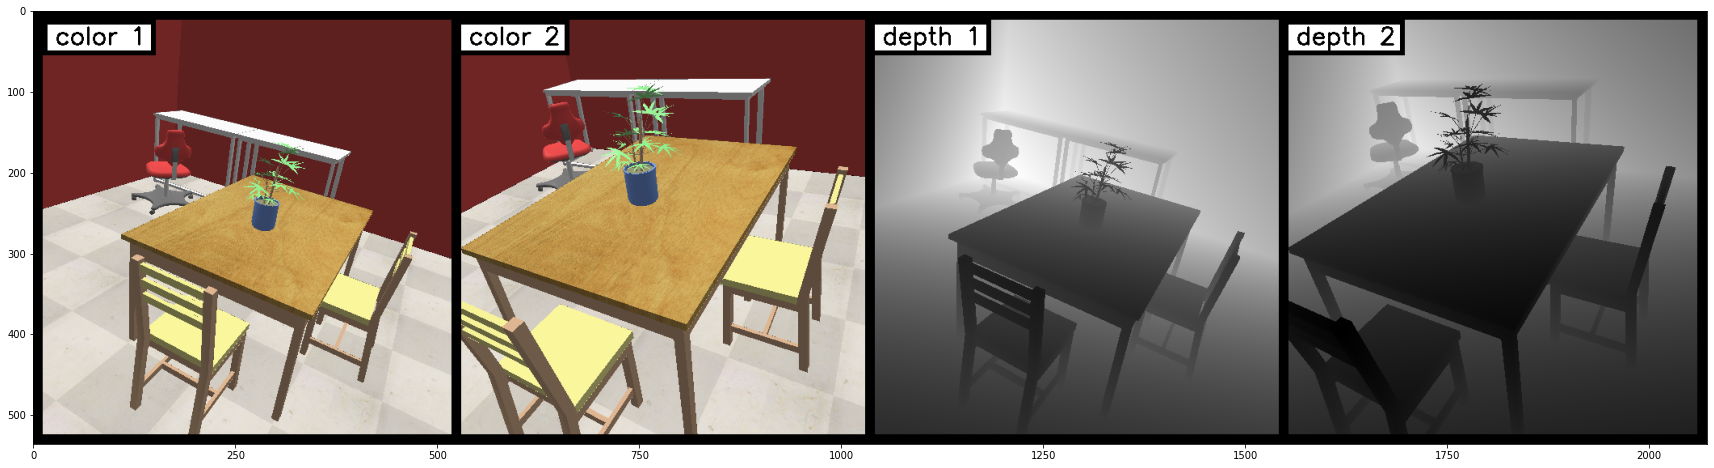

In [15]:
show_rgb_and_depth_images(color1, color2, depth1, depth2, depth_limits)

# Flow and Depth Triangulation

## Required Matrix Formats

In [16]:
cam1to2_full_mat_homo = ivy.matmul(cam2_geom.full_mats_homo, cam1_geom.inv_full_mats_homo)
cam1to2_full_mat = cam1to2_full_mat_homo[..., 0:3, :]
full_mats_homo = ivy.concatenate((ivy.expand_dims(cam1_geom.full_mats_homo, 0),
                                  ivy.expand_dims(cam2_geom.full_mats_homo, 0)), 0)
full_mats = full_mats_homo[..., 0:3, :]

## Optical Flow

In [17]:
flow1to2 = ivy_vision.flow_from_depth_and_cam_mats(ds_pixel_coords1, cam1to2_full_mat)

## Depth Again

In [18]:
depth1_from_flow = ivy_vision.depth_from_flow_and_cam_mats(flow1to2, full_mats)

## Show

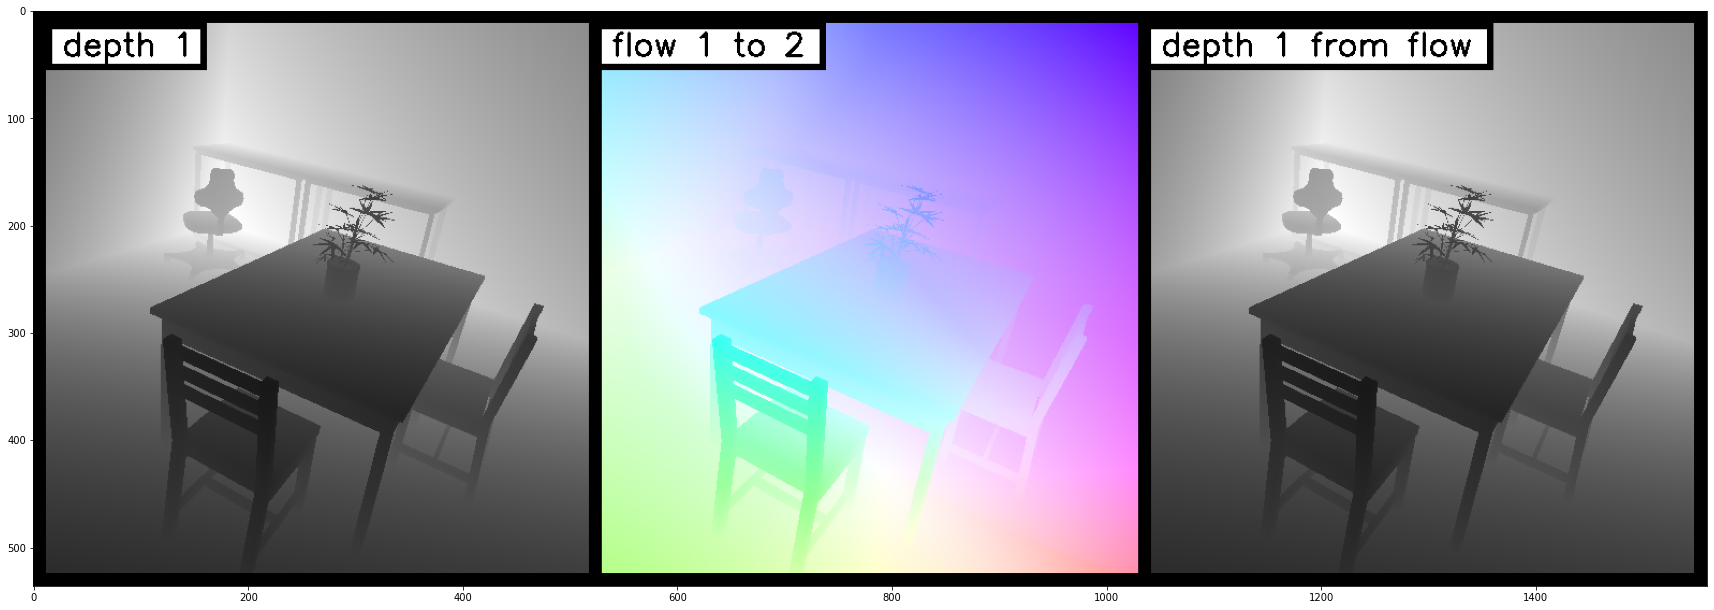

In [19]:
show_flow_and_depth_images(depth1, flow1to2, depth1_from_flow, depth_limits)

# Inverse Warping

## Inverse Warp Rendering

In [20]:
warp = u_pix_coords[..., 0:2] + flow1to2
color2_warp_to_f1 = ivy.reshape(ivy.bilinear_resample(color2, warp), color1.shape)

## Projected Depth Scaled  Pixel Coords wrt Frame 2

In [21]:
ds_pixel_coords1_wrt_f2 = ivy_vision.ds_pixel_to_ds_pixel_coords(ds_pixel_coords1, cam1to2_full_mat)

## Projected Depth wrt Frame 2

In [22]:
depth1_wrt_f2 = ds_pixel_coords1_wrt_f2[..., -1:]

## Frame 2 Depth Warped to Frame 1

In [23]:
depth2_warp_to_f1 = ivy.reshape(ivy.bilinear_resample(depth2, warp), depth1.shape)

## Depth Validity

In [24]:
depth_validity = ivy.abs(depth1_wrt_f2 - depth2_warp_to_f1) < 0.01

## Frame 2 Color Warped to Frame 1 with Mask

In [25]:
color2_warp_to_f1_masked = ivy.where(depth_validity, color2_warp_to_f1, ivy.zeros_like(color2_warp_to_f1))

## Show

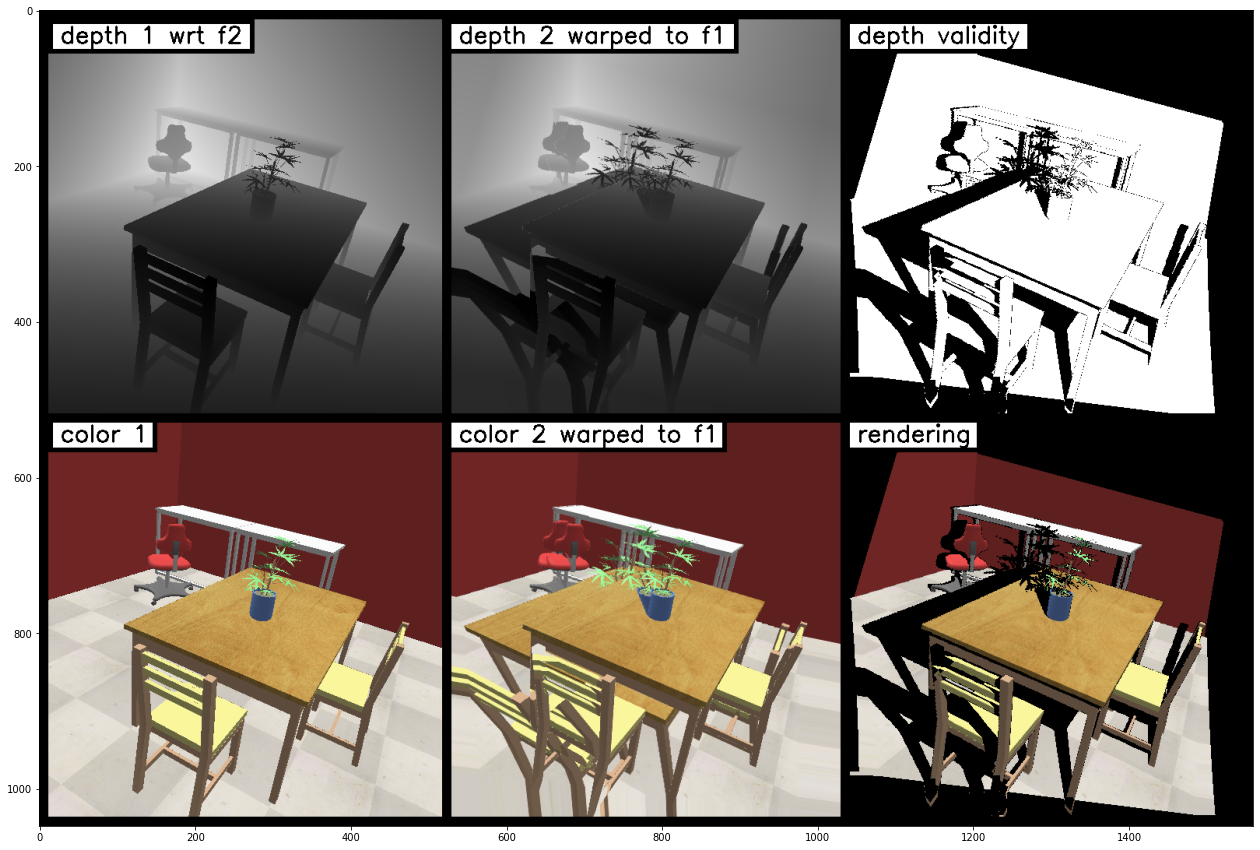

In [26]:
show_inverse_warped_images(depth1_wrt_f2, depth2_warp_to_f1, depth_validity,
                            color1, color2_warp_to_f1, color2_warp_to_f1_masked, depth_limits)

# Forward Warping

## Forward Warp Rendering

In [27]:
ds_pixel_coords1_proj = ivy_vision.ds_pixel_to_ds_pixel_coords(
    ds_pixel_coords2, ivy.inv(cam1to2_full_mat_homo)[..., 0:3, :])
depth1_proj = ds_pixel_coords1_proj[..., -1:]
ds_pixel_coords1_proj = ds_pixel_coords1_proj[..., 0:2] / depth1_proj
features_to_render = ivy.concatenate((depth1_proj, color2), -1)

## Without Depth Buffer

In [28]:
f1_forward_warp_no_db, _, _ = ivy_vision.quantize_to_image(
    ivy.reshape(ds_pixel_coords1_proj, (-1, 2)), img_dims, ivy.reshape(features_to_render, (-1, 4)),
    ivy.zeros_like(features_to_render), with_db=False)

## With Depth Buffer

In [29]:
f1_forward_warp_w_db, _, _ = ivy_vision.quantize_to_image(
    ivy.reshape(ds_pixel_coords1_proj, (-1, 2)), img_dims, ivy.reshape(features_to_render, (-1, 4)),
    ivy.zeros_like(features_to_render), with_db=False if ivy.get_framework() == 'mxnet' else True)

## Show

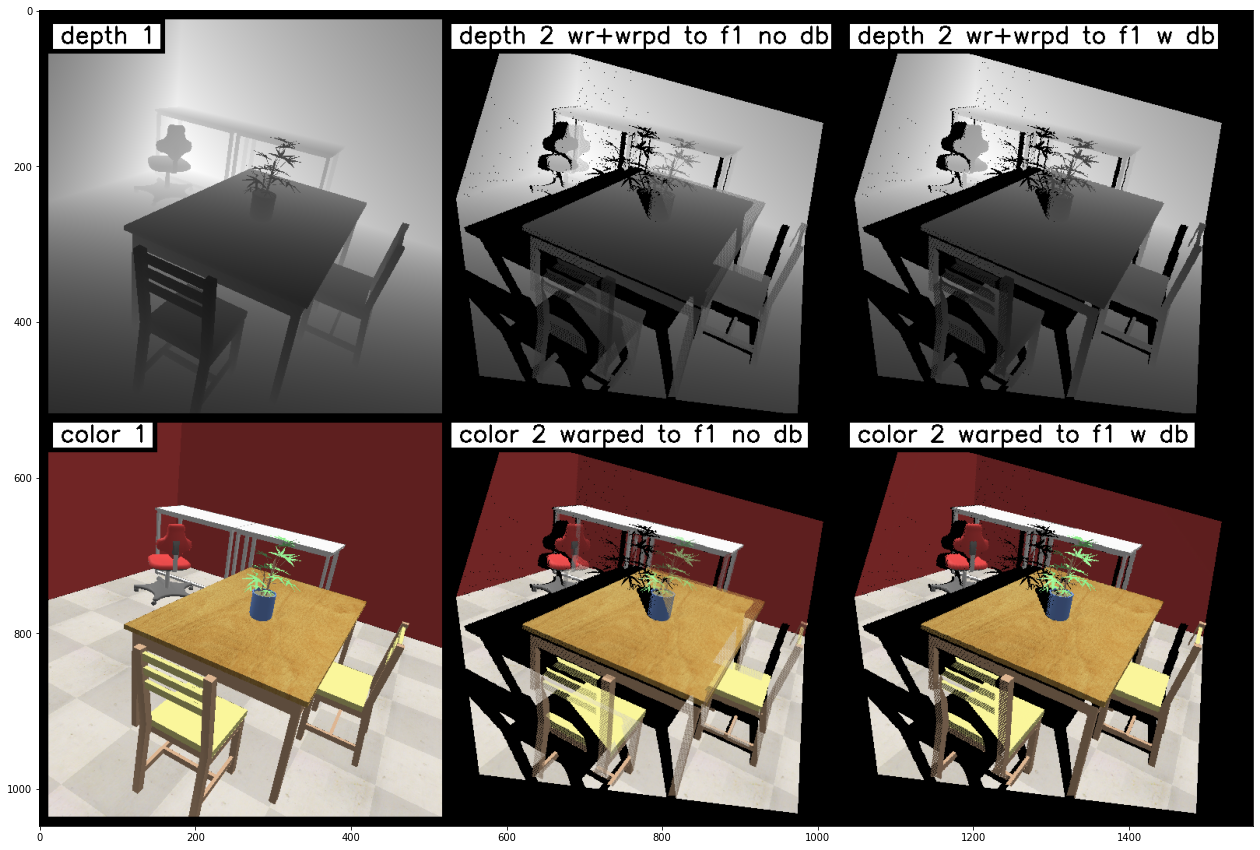

In [30]:
show_forward_warped_images(depth1, color1, f1_forward_warp_no_db, f1_forward_warp_w_db, depth_limits)